# Dont run this cell if you dont see any error

In [ ]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 72.0/72.0 MB 53.2 MB/s eta 

# Start From Here

put your 3 csv file into MyDrive with folder name data2 :

name of the csv files should be cus.csv,res.csv,rev.csv



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data3

/content/drive/MyDrive/data3


In [ ]:
#doo

# Edit Data

In [ ]:
import collections
from tensorflow.keras.models import load_model
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple
## for machine learning
from sklearn import metrics, preprocessing
## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(42)

In [ ]:
def create_customer_df(path):
  cust = pd.read_csv(path)
  columns_to_vectorize = ['interest_preference', 'ambience_preference', 'cuisine_preference', 'flavor_preference']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs.append(cust['customer_id'])
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = cust[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)
  vectorized_dfs.append(cust['budget_customer'])

  result_cus = pd.concat(vectorized_dfs, axis=1)
  return result_cus




In [ ]:
def create_review_df(path):
  rev = pd.read_csv('rev.csv')
  columns_to_vectorize = ['customer_need_fast_slow']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs= [rev['id_review'],rev['customer_id'],rev['restaurant_id'],rev['taste_rating'],rev["ambiance_rating"],rev['overall_rating'],rev['reason_of_visit']]
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = rev[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)

  result_rev = pd.concat(vectorized_dfs, axis=1)
  return result_rev

In [ ]:
#alternative
def create_restaurant_df(path):
  res = pd.read_csv(path)
  columns_to_vectorize = ['flavors','profile','ambiance','cuisine','reason_of_visit_restaurant']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs= [res['restaurant_id'],res['budget']]
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = res[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)

  result_rev = pd.concat(vectorized_dfs, axis=1)
  return result_rev

In [ ]:
def merge_dataframes(review_df,customer_df,restaurant_df):
  merged_df = pd.merge(review_df, customer_df, on='customer_id')
  merged_df = pd.merge(merged_df, restaurant_df, on='restaurant_id')
  return merged_df

In [ ]:
customer_df=create_customer_df('cus.csv')
review_df=create_review_df('rev.csv')
restaurant_df=create_restaurant_df('res.csv').sort_values("restaurant_id")
merged_df=merge_dataframes(review_df,customer_df,restaurant_df)
merged_df=merged_df.sort_values("customer_id")

In [ ]:
merged_df

,id_review,customer_id,restaurant_id,taste_rating,ambiance_rating,overall_rating,reason_of_visit,customer_need_fast_slow,interest_preference,ambience_preference,cuisine_preference,flavor_preference,budget_customer,budget,flavors,profile,ambiance,cuisine,reason_of_visit_restaurant
0,0,0,12,9,10,9.00,Guest,Fast|Slow,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,3,3,tofu|vegeterian|cheese,Theatre|Student,Elegant|Romantic,Vegetarian,Date
13643,25,0,312,1,10,5.25,Friend,Slow,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,3,1,burrito|indigenous|grill|taco,Experiments|StandUp,Romantic,LatinAmerican,Friend|Date|Family
12332,24,0,440,6,9,7.75,Date,Slow,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,3,3,bread|fresh|vegetable,Traveller|SportsPerson|Cinema,Ethnic,French,Work|Family|Date
12331,23,0,440,6,10,6.75,Date,Fast,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,3,3,bread|fresh|vegetable,Traveller|SportsPerson|Cinema,Ethnic,French,Work|Family|Date
12330,22,0,440,8,9,8.25,Date,Fast|Slow,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,3,3,bread|fresh|vegetable,Traveller|SportsPerson|Cinema,Ethnic,French,Work|Family|Date
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142583,942266,34999,43,7,4,6.25,Date,Fast|Slow,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,1,1,snacks|wine|tapas,Theatre|Businessman|Experiments,Ethnic|Cozy,BarPubBrewery,Friend|Guest|Family
924313,942271,34999,453,9,10,9.50,Guest,Fast|Slow,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,1,2,burrito|modern|chicken|spicy,Student|Family,Sport|FineDining,Mexican,Family|Friend|Date
924312,942270,34999,453,1,9,5.00,Guest,Slow,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,1,2,burrito|modern|chicken|spicy,Student|Family,Sport|FineDining,Mexican,Family|Friend|Date
843908,942251,34999,27,6,1,4.00,Friend,Fast,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,1,3,souce|pizza|tapas,StandUp|Businessman,Ethnic|FamilyFriendly|Cozy,Pizzeria,Guest|Friend|Family


In [ ]:
review_df.groupby([	'restaurant_id'], as_index=False)['restaurant_id','taste_rating','overall_rating','ambiance_rating','service_rating'].mean().to_csv("PinarYig.csv")

<ipython-input-11-bd363c7926e4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  review_df.groupby([	'restaurant_id'], as_index=False)['restaurant_id','taste_rating','overall_rating','ambiance_rating','service_rating'].mean().to_csv("PinarYig.csv")


KeyError: ignored

# Statistics

In [ ]:
def show_statistical_distribution(df_and_column):
  ratings = df_and_columns
  plt.hist(ratings, bins=5)
  plt.xticks([1, 2, 3, 4, 5,6,7,8,9,10])
  plt.ylabel('Count')
  plt.xlabel('Rating')
  plt.show()
  print('Average rating:', np.mean(ratings))
  print('Median rating:', np.median(ratings))

show_statistical_distribution(merged_df.ambiance_rating)

In [ ]:
cus_list = merged_df.ambience_preference
# Count the number of times each genre describes a movie.
genre_count = collections.defaultdict(int)
for genres in cus_list:
  curr_genres_list = genres.split('|')
  for genre in curr_genres_list:
    genre_count[genre] += 1
genre_name_list, genre_count_list = zip(*genre_count.items())

plt.figure(figsize=(11, 11))
plt.pie(genre_count_list, labels=genre_name_list)
plt.title('Customer Ambiance')
plt.show()

In [ ]:
cus_list = result_cus.cuisine_preference
# Count the number of times each genre describes a movie.
genre_count = collections.defaultdict(int)
for genres in cus_list:
  curr_genres_list = genres.split('|')
  for genre in curr_genres_list:
    genre_count[genre] += 1
genre_name_list, genre_count_list = zip(*genre_count.items())

plt.figure(figsize=(11, 11))
plt.pie(genre_count_list, labels=genre_name_list)
plt.title('Customer Cuisine')
plt.show()

In [ ]:
cus_list = result_cus.interest_preference
# Count the number of times each genre describes a movie.
genre_count = collections.defaultdict(int)
for genres in cus_list:
  curr_genres_list = genres.split('|')
  for genre in curr_genres_list:
    genre_count[genre] += 1
genre_name_list, genre_count_list = zip(*genre_count.items())

plt.figure(figsize=(11, 11))
plt.pie(genre_count_list, labels=genre_name_list)
plt.title('Customer Interests')
plt.show()

In [ ]:
def print_top_genres_for_user(ratings_df, res_df, customer_id):
  """Prints top movie genres for user with ID user_id."""
  user_ratings_df = ratings_df[ratings_df.customer_id == customer_id]
  restaurant_ids = user_ratings_df.restaurant_id

  genre_count = collections.Counter()
  for restaurant_id in restaurant_ids:
    genres_string = res_df[res_df.restaurant_id == restaurant_id].cuisine.tolist()[0]
    for genre in genres_string.split('|'):
      genre_count[genre] += 1

  print(f'\nFor user {customer_id}:')
  for (genre, freq) in genre_count.most_common(5):
    print(f'{genre} was rated {freq} times')

print_top_genres_for_user(merged_df, res, customer_id=0)
print_top_genres_for_user(merged_df, res, customer_id=10)
print_top_genres_for_user(merged_df, res, customer_id=22)

# Taste Matching

In [ ]:
def taste_matching_users(merged_df):
  dtf_users=merged_df[['customer_id',	'restaurant_id','cuisine_preference',	'flavor_preference','taste_rating' ]]
  dtf_users = dtf_users.groupby(['customer_id',	'restaurant_id','cuisine_preference',	'flavor_preference'], as_index=False)['taste_rating'].mean()
  return dtf_users
taste_users_df = taste_matching_users(merged_df)


In [ ]:
taste_users_df

,customer_id,restaurant_id,cuisine_preference,flavor_preference,taste_rating
0,0,12,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,7.000000
1,0,41,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,6.000000
2,0,144,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,2.000000
3,0,168,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,2.000000
4,0,268,Bar|Cafeteria,beer|fry|bread|cofee|cocktail,8.000000
...,...,...,...,...,...
436113,34999,370,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,8.444444
436114,34999,388,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,7.666667
436115,34999,401,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,7.000000
436116,34999,440,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...,8.000000


In [ ]:
taste_users_df = taste_users_df.rename(columns={"taste_rating":"y"})

In [ ]:
taste_context_df = taste_users_df[['customer_id',	'restaurant_id','cuisine_preference',	'flavor_preference' ]]
taste_context_df=taste_context_df.sort_values('customer_id').set_index(["customer_id","restaurant_id"])
taste_context_df

cuisine_preference  \
customer_id restaurant_id                                              
0           12                                         Bar|Cafeteria   
            440                                        Bar|Cafeteria   
            420                                        Bar|Cafeteria   
            336                                        Bar|Cafeteria   
            312                                        Bar|Cafeteria   
...                                                              ...   
34999       27             Contemporary|Sandwiches|French|Vegetarian   
            20             Contemporary|Sandwiches|French|Vegetarian   
            440            Contemporary|Sandwiches|French|Vegetarian   
            290            Contemporary|Sandwiches|French|Vegetarian   
            453            Contemporary|Sandwiches|French|Vegetarian   

                                                           flavor_preference  
customer_id restaurant_id                                                     
0           12                                 beer|fry|bread|cofee|cocktail  
            440                                beer|fry|bread|cofee|cocktail  
            420                                beer|fry|bread|cofee|cocktail  
            336                                beer|fry|bread|cofee|cocktail  
            312                                beer|fry|bread|cofee|cocktail  
...                                                                      ...  
34999       27             burger|meat|salad|sandwich|grill|truffle|herbs...  
            20             burger|meat|salad|sandwich|grill|truffle|herbs...  
            440            burger|meat|salad|sandwich|grill|truffle|herbs...  
            290            burger|meat|salad|sandwich|grill|truffle|herbs...  
            453            burger|meat|salad|sandwich|grill|truffle|herbs...  

[436118 rows x 2 columns]

In [ ]:
import copy
def taste_matching_products(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["cuisine"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags

  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    print(col)
    res2[colname] = res2["cuisine"].apply(lambda x: 1 if col == x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products
taste_products_df2 = taste_matching_products(restaurant_df)
taste_products_df2= taste_products_df2.set_index("restaurant_id").drop("flavors",axis=1).drop("profile",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1)
taste_products_df2

Italian
Turkish
African
Mexican
Dutch
Sandwiches
Coffee
Asian
American
Korean
Juice
IceCream
Vegetarian
Pizzeria
Cafeteria
FastFood
BarPubBrewery
Greek
LatinAmerican
Japanese
Chinese
Wine
Seafood
Bar
Bakery
Burgers
International
Steaks
Contemporary
French


,budget,cuisine,Italian,Turkish,African,Mexican,Dutch,Sandwiches,Coffee,Asian,...,Chinese,Wine,Seafood,Bar,Bakery,Burgers,International,Steaks,Contemporary,French
restaurant_id,,,,,,,,,,,,,,,,,,,,,
0,3,LatinAmerican,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,French,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,Burgers,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2,African,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,Turkish,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,Contemporary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
496,2,Juice,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,2,Burgers,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
def taste_matching_products_flavors(res):
  res2=copy.deepcopy(res)
  tags = [i.split("|") for i in res["flavors"].unique()]
  print(tags)
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      print(col)
      res2[col] = res2["flavors"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

taste_products_df = taste_matching_products_flavors(restaurant_df)
taste_products_df= taste_products_df.set_index("restaurant_id")
taste_products_df= taste_products_df.drop("cuisine",axis=1).drop("flavors",axis=1).drop("profile",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1)


[['patato', 'burrito', 'vegetable', 'grill'], ['truffle', 'chocolate', 'soup'], ['fry', 'snack', 'burger'], ['meat', 'bread', 'curry'], ['boiled', 'tapas', 'kebab', 'spicy'], ['juice', 'sweet', 'cake', 'cofee'], ['souce', 'smoothie', 'salad'], ['grill', 'bread', 'fermented'], ['vegetable', 'oil', 'pasta'], ['souce', 'pizza', 'sweet', 'sandwich'], ['spicy', 'aromatic', 'noodle'], ['vegetable', 'fresh', 'tapas'], ['tofu', 'vegeterian', 'cheese'], ['tapas', 'oil', 'tomato', 'bbq'], ['fermented', 'spicy', 'chicken', 'rice'], ['cheese', 'vegeterian', 'tofu', 'salad'], ['cake', 'bread', 'smoothie'], ['tofu', 'cake', 'cheese'], ['burger', 'aromatic', 'pizza'], ['patato', 'sousage', 'chicken'], ['cocktail', 'sweet', 'waffle'], ['spicy', 'seafood', 'tomato'], ['salty', 'cofee', 'bread', 'juice'], ['sousage', 'patato', 'chicken', 'boiled'], ['burrito', 'patato', 'modern', 'salsa'], ['boiled', 'oil', 'fish', 'tomato'], ['tempura', 'fresh', 'aromatic'], ['souce', 'pizza', 'tapas'], ['modern', 'tap

In [ ]:

taste_products_df= taste_products_df.merge(taste_products_df2, how="left", left_on="restaurant_id", right_index=True)
taste_products_df

,budget_x,truffle,boiled,cake,juice,modern,souce,tomato,snacks,fresh,...,Chinese,Wine,Seafood,Bar,Bakery,Burgers,International,Steaks,Contemporary,French
restaurant_id,,,,,,,,,,,,,,,,,,,,,
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
496,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
497,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
def prepare_users_for_collobrative_filtering(dtf_users,dtf_products):
  tmp = dtf_users.copy()
  dtf_users = tmp.pivot_table(index="customer_id", columns="restaurant_id", values="y")
  missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
  for col in missing_cols:
      dtf_users[col] = np.nan
  dtf_users = dtf_users[sorted(dtf_users.columns)]
  dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), columns=dtf_users.columns, index=dtf_users.index)
  return dtf_users
taste_users_df = prepare_users_for_collobrative_filtering(taste_users_df,taste_products_df)


In [ ]:

dtf_train = taste_users_df
dtf_train

restaurant_id,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
customer_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,NaN
34997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.555556,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def prepare_context_taste(dtf_context):
  dtf_context_=dtf_context
  tags = [i.split("|") for i in dtf_context["cuisine_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      dtf_context_[col] = dtf_context["cuisine_preference"].apply(lambda x: 1 if col in x else 0)
  tags = [i.split("|") for i in dtf_context["flavor_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
  dtf_context_3= dtf_context_
  dtf_context_3=dtf_context_3.drop(['cuisine_preference','flavor_preference'], axis=1)
  return dtf_context_3

taste_context_df= prepare_context_taste(taste_context_df)
taste_context_df

<ipython-input-23-0071978d26f5>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-23-0071978d26f5>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-23-0071978d26f5>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Italian  Turkish  Asian  African  Dutch  Coffee  \
customer_id restaurant_id                                                    
0           12                   0        0      0        0      0       0   
            440                  0        0      0        0      0       0   
            420                  0        0      0        0      0       0   
            336                  0        0      0        0      0       0   
            312                  0        0      0        0      0       0   
...                            ...      ...    ...      ...    ...     ...   
34999       27                   0        0      0        0      0       0   
            20                   0        0      0        0      0       0   
            440                  0        0      0        0      0       0   
            290                  0        0      0        0      0       0   
            453                  0        0      0        0      0       0   

                           Mexican  American  Sandwiches  Korean  ...  smoke  \
customer_id restaurant_id                                         ...          
0           12                   0         0           0       0  ...      0   
            440                  0         0           0       0  ...      0   
            420                  0         0           0       0  ...      0   
            336                  0         0           0       0  ...      0   
            312                  0         0           0       0  ...      0   
...                            ...       ...         ...     ...  ...    ...   
34999       27                   0         0           1       0  ...      0   
            20                   0         0           1       0  ...      0   
            440                  0         0           1       0  ...      0   
            290                  0         0           1       0  ...      0   
            453                  0         0           1       0  ...      0   

                           sandwich  curry  feta  cocktail  fish  sousage  \
customer_id restaurant_id                                                   
0           12                    0      0     0         1     0        0   
            440                   0      0     0         1     0        0   
            420                   0      0     0         1     0        0   
            336                   0      0     0         1     0        0   
            312                   0      0     0         1     0        0   
...                             ...    ...   ...       ...   ...      ...   
34999       27                    1      0     0         0     0        0   
            20                    1      0     0         0     0        0   
            440                   1      0     0         0     0        0   
            290                   1      0     0         0     0        0   
            453                   1      0     0         0     0        0   

                           fry  burger  oil  
customer_id restaurant_id                    
0           12               1       0    0  
            440              1       0    0  
            420              1       0    0  
            336              1       0    0  
            312              1       0    0  
...                        ...     ...  ...  
34999       27               0       1    0  
            20               0       1    0  
            440              0       1    0  
            290              0       1    0  
            453              0       1    0  

[436118 rows x 113 columns]

In [ ]:
for col in taste_context_df.columns:
  if 1 == taste_context_df.iloc[24][col]:
    print(col,taste_context_df.iloc[24][col])

IceCream 1
FastFood 1
sweet 1
meat 1
chocolate 1
chicken 1
beer 1
waffle 1


In [ ]:
taste_context_df

Italian  Turkish  Asian  African  Dutch  Coffee  \
customer_id restaurant_id                                                    
0           12                   0        0      0        0      0       0   
            440                  0        0      0        0      0       0   
            420                  0        0      0        0      0       0   
            336                  0        0      0        0      0       0   
            312                  0        0      0        0      0       0   
...                            ...      ...    ...      ...    ...     ...   
34999       27                   0        0      0        0      0       0   
            20                   0        0      0        0      0       0   
            440                  0        0      0        0      0       0   
            290                  0        0      0        0      0       0   
            453                  0        0      0        0      0       0   

                           Mexican  American  Sandwiches  Korean  ...  smoke  \
customer_id restaurant_id                                         ...          
0           12                   0         0           0       0  ...      0   
            440                  0         0           0       0  ...      0   
            420                  0         0           0       0  ...      0   
            336                  0         0           0       0  ...      0   
            312                  0         0           0       0  ...      0   
...                            ...       ...         ...     ...  ...    ...   
34999       27                   0         0           1       0  ...      0   
            20                   0         0           1       0  ...      0   
            440                  0         0           1       0  ...      0   
            290                  0         0           1       0  ...      0   
            453                  0         0           1       0  ...      0   

                           sandwich  curry  feta  cocktail  fish  sousage  \
customer_id restaurant_id                                                   
0           12                    0      0     0         1     0        0   
            440                   0      0     0         1     0        0   
            420                   0      0     0         1     0        0   
            336                   0      0     0         1     0        0   
            312                   0      0     0         1     0        0   
...                             ...    ...   ...       ...   ...      ...   
34999       27                    1      0     0         0     0        0   
            20                    1      0     0         0     0        0   
            440                   1      0     0         0     0        0   
            290                   1      0     0         0     0        0   
            453                   1      0     0         0     0        0   

                           fry  burger  oil  
customer_id restaurant_id                    
0           12               1       0    0  
            440              1       0    0  
            420              1       0    0  
            336              1       0    0  
            312              1       0    0  
...                        ...     ...  ...  
34999       27               0       1    0  
            20               0       1    0  
            440              0       1    0  
            290              0       1    0  
            453              0       1    0  

[436118 rows x 113 columns]

In [ ]:
train_taste = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train_taste=train_taste.set_index(["customer_id","restaurant_id"])
## add features
joined_df = train_taste.join(taste_products_df, on='restaurant_id')
## add context
final_df = joined_df.join(taste_context_df.add_suffix('_context'), on=['customer_id', 'restaurant_id'])
train_taste = final_df



In [ ]:
for col in train_taste.columns:
  if 1 == train_taste.iloc[55][col]:
    print(col,train_taste.iloc[55][col])

budget_x 1
modern 1
tofu 1
patato 1
budget_y 1
Burgers 1
Korean_context 1
Greek_context 1
Wine_context 1
Burgers_context 1
souce_context 1
meat_context 1
cheese_context 1
modern_context 1
seafood_context 1
soup_context 1
rice_context 1
vegeterian_context 1
tapas_context 1
smoke_context 1
burger_context 1
oil_context 1


In [ ]:
train_taste.iloc[0]["Vegetarian"]

1

In [ ]:
features_taste = ['salsa',
 'curry',
 'noodle',
 'soup',
 'herbs',
 'aromatic',
 'stew',
 'wrap',
 'tempura',
 'meat',
 'waffle',
 'fresh',
 'snacks',
 'tex_mex',
 'cheese',
 'vegeterian',
 'truffle',
 'bread',
 'risotto',
 'pasta',
 'sandwich',
 'tomato',
 'seafood',
 'doner',
 'burger',
 'juice',
 'beer',
 'charcuterie',
 'modern',
 'tofu',
 'patato',
 'fish',
 'sushi',
 'salad',
 'burrito',
 'pastry',
 'bbq',
 'fry',
 'chocolate',
 'taco',
 'tapas',
 'kebab',
 'smoke',
 'oil',
 'spicy',
 'grill',
 'cofee',
 'kimchi',
 'wine',
 'global',
 'snack',
 'tea',
 'shrimp',
 'fusion',
 'mcncheese',
 'sousage',
 'pizza',
 'fruit',
 'chicken',
 'smoothie',
 'souce',
 'fermented',
 'indigenous',
 'rice',
 'sweet',
 'panini',
 'boiled',
 'pubfood',
 'cocktail',
 'crab',
 'vegetable',
 'salty',
 'eclectic',
 'cake',
 'icecream',
 'ramen',
 'Asian',
 'Vegetarian',
 'Japanese',
 'Mexican',
 'Wine',
 'Greek',
 'Coffee',
 'Burgers',
 'Pizzeria',
 'Contemporary',
 'Bar',
 'LatinAmerican',
 'Chinese',
 'Seafood',
 'Italian',
 'Korean',
 'Cafeteria',
 'Juice',
 'Dutch',
 'FastFood',
 'Bakery',
 'American',
 'French',
 'Turkish',
 'African',
 'Sandwiches',
 'IceCream',
 'International',
 'BarPubBrewery',
 'Steaks']


context_taste = ['Asian_context',
 'Vegetarian_context',
 'Japanese_context',
 'Mexican_context',
 'Wine_context',
 'Greek_context',
 'Coffee_context',
 'Burgers_context',
 'Pizzeria_context',
 'Contemporary_context',
 'Bar_context',
 'LatinAmerican_context',
 'Chinese_context',
 'Korean_context',
 'Italian_context',
 'Seafood_context',
 'Cafeteria_context',
 'Juice_context',
 'Dutch_context',
 'FastFood_context',
 'Bakery_context',
 'American_context',
 'French_context',
 'Turkish_context',
 'African_context',
 'IceCream_context',
 'International_context',
 'BarPubBrewery_context',
 'Sandwiches_context',
 'Steaks_context',
 'noodle_context',
 'soup_context',
 'meat_context',
 'fresh_context',
 'snacks_context',
 'mustard_context',
 'seafood_context',
 'burger_context',
 'beer_context',
 'juice_context',
 'fish_context',
 'smoke_context',
 'mcncheese_context',
 'snack_context',
 'shrimp_context',
 'fruit_context',
 'pubfood_context',
 'cocktail_context',
 'indigenous_context',
 'diverse_context',
 'wrap_context',
 'cheese_context',
 'sushi_context',
 'salad_context',
 'burrito_context',
 'kebab_context',
 'souvlaki_context',
 'grill_context',
 'cofee_context',
 'kimchi_context',
 'fermented_context',
 'baklava_context',
 'cake_context',
 'ramen_context',
 'salsa_context',
 'aromatic_context',
 'stew_context',
 'tempura_context',
 'waffle_context',
 'tex_mex_context',
 'truffle_context',
 'bread_context',
 'pasta_context',
 'sandwich_context',
 'tomato_context',
 'umami_context',
 'world_context',
 'doner_context',
 'charcuterie_context',
 'modern_context',
 'tofu_context',
 'pastry_context',
 'chocolate_context',
 'oil_context',
 'tapas_context',
 'wine_context',
 'global_context',
 'fusion_context',
 'sousage_context',
 'chicken_context',
 'smoothie_context',
 'sweet_context',
 'panini_context',
 'boiled_context',
 'crab_context',
 'vegetable_context',
 'eclectic_context',
 'curry_context',
 'herbs_context',
 'vegeterian_context',
 'risotto_context',
 'patato_context',
 'bbq_context',
 'fry_context',
 'taco_context',
 'spicy_context',
 'tea_context',
 'pizza_context',
 'feta_context',
 'souce_context',
 'rice_context',
 'salty_context',
 'icecream_context']

In [ ]:
dtf_train.shape

(35000, 500)

# end opt

In [ ]:
import keras
embeddings_size = 64
usr, prd = dtf_train.shape[0], dtf_train.shape[1]
feat = len(features_taste)
ctx = len(context_taste)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model_taste = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
optimizer = keras.optimizers.Adam(lr=0.000001)
model_taste.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
model_taste.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 64)        2240000     ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 64)        32000       ['xproducts_in[0][0]']           
                                                                                       

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


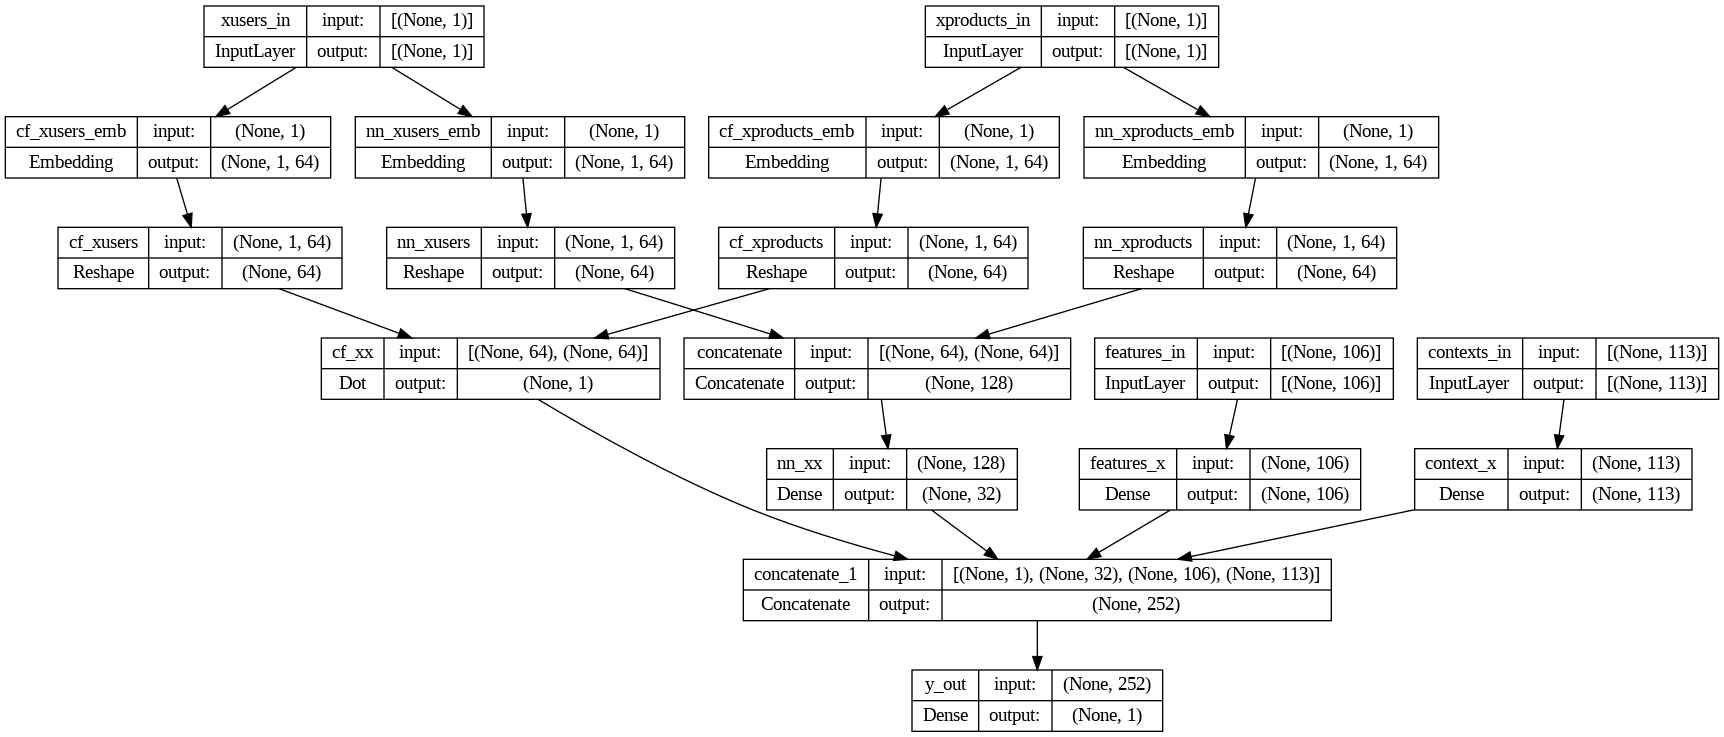

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_taste, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()


In [ ]:
train_taste=train_taste.reset_index()


In [ ]:
train_taste

,customer_id,restaurant_id,y,budget_x,risotto,smoke,oil,salad,meat,cake,...,chocolate_context,aromatic_context,sweet_context,charcuterie_context,rice_context,eclectic_context,tomato_context,patato_context,tex_mex_context,sandwich_context
0,0,12,0.833333,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,41,0.777778,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,144,0.555556,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,168,0.555556,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,268,0.888889,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436113,34999,370,0.913580,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
436114,34999,388,0.870370,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
436115,34999,401,0.833333,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
436116,34999,440,0.888889,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


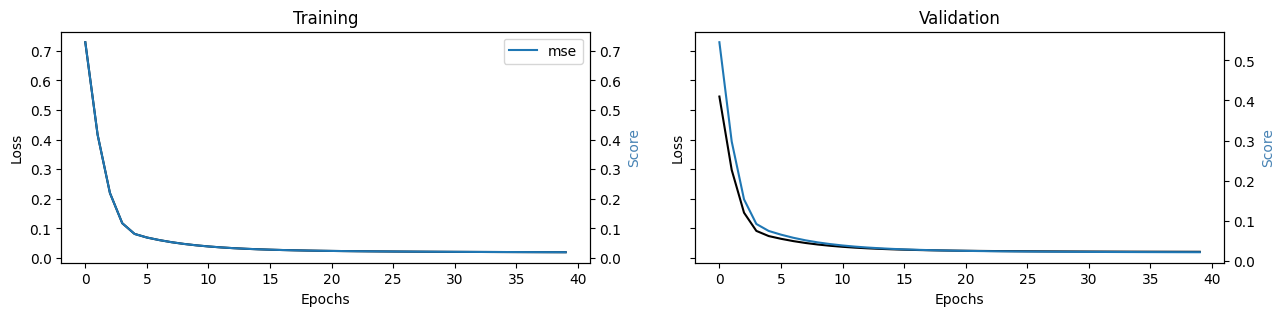

In [ ]:
# train
training = model_taste.fit(x=[train_taste["customer_id"], train_taste["restaurant_id"], train_taste[features_taste], train_taste[context_taste]], y=train_taste["y"],
                     epochs=40, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model_taste = training.model
utils_plot_keras_training(training)

In [ ]:
model_taste.save('last_good_taste_for_real_40')

# FOR AMBIANCE MATCHING

In [ ]:
ambiance_users_df=merged_df[['customer_id',	'restaurant_id','reason_of_visit','interest_preference',	'ambience_preference','ambiance_rating' ]].groupby(['customer_id',	'restaurant_id','reason_of_visit','interest_preference',	'ambience_preference'], as_index=False)['ambiance_rating'].mean()
ambiance_products_df= restaurant_df[['restaurant_id','profile','ambiance','reason_of_visit_restaurant']].set_index("restaurant_id")
ambiance_users_df = ambiance_users_df.rename(columns={"ambiance_rating":"y"})

In [ ]:
ambiance_users_df

,customer_id,restaurant_id,reason_of_visit,interest_preference,ambience_preference,y
0,0,12,Guest,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,10.000000
1,0,41,Guest,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,10.000000
2,0,144,Guest,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,9.000000
3,0,168,Friend,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,1.000000
4,0,268,Friend,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,9.000000
...,...,...,...,...,...,...
436113,34999,370,Work,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,9.555556
436114,34999,388,Guest,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,9.666667
436115,34999,401,Work,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,10.000000
436116,34999,440,Guest,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,4.000000


In [ ]:
def prepare_users_for_collobrative_filtering(dtf_users,dtf_products):
  tmp = dtf_users.copy()
  dtf_users = tmp.pivot_table(index="customer_id", columns="restaurant_id", values="y")
  missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
  for col in missing_cols:
      dtf_users[col] = np.nan
  dtf_users = dtf_users[sorted(dtf_users.columns)]
  dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), columns=dtf_users.columns, index=dtf_users.index)
  return dtf_users


In [ ]:
import copy
dtf_train_ambiance = prepare_users_for_collobrative_filtering(ambiance_users_df,ambiance_products_df)
dtf_train_ambiance

cus_amb = copy.deepcopy(dtf_train_ambiance)

In [ ]:
import copy
ambiance_context_df = copy.deepcopy(ambiance_users_df[['customer_id',	'restaurant_id','ambience_preference',	'reason_of_visit',"interest_preference" ]])
ambiance_context_df=ambiance_context_df.sort_values('customer_id').set_index(["customer_id","restaurant_id"])
ambiance_context_df

tags = [i.split("|") for i in ambiance_context_df["ambience_preference"].unique()]
columns = list(set([i for lst in tags for i in lst]))
dtf_context_=ambiance_context_df
for col in columns:
    dtf_context_[col] = ambiance_context_df["ambience_preference"].apply(lambda x: 1 if col in x else 0)

tags = [i.split("|") for i in ambiance_context_df["reason_of_visit"].unique()]
columns = list(set([i for lst in tags for i in lst]))
for col in columns:
    dtf_context_[col] = ambiance_context_df["reason_of_visit"].apply(lambda x: 1 if col in x else 0)

tags = [i.split("|") for i in ambiance_context_df["interest_preference"].unique()]
columns = list(set([i for lst in tags for i in lst]))
for col in columns:
    rename_col = col
    if col == "Family":
      rename_col = "Family_profile"
    dtf_context_[rename_col] = ambiance_context_df["interest_preference"].apply(lambda x: 1 if col in x else 0)


dtf_context_3= dtf_context_
dtf_context_3=dtf_context_3.drop(['reason_of_visit','ambience_preference','interest_preference'], axis=1)

dtf_context_3

Romantic  FineDining  CasualDining  Cozy  Elegant  \
customer_id restaurant_id                                                      
0           12                    1           0             1     0        0   
            440                   1           0             1     0        0   
            420                   1           0             1     0        0   
            336                   1           0             1     0        0   
            312                   1           0             1     0        0   
...                             ...         ...           ...   ...      ...   
34999       27                    1           1             0     0        0   
            20                    1           1             0     0        0   
            440                   1           1             0     0        0   
            290                   1           1             0     0        0   
            453                   1           1             0     0        0   

                           Lively  Sport  Ethnic  FamilyFriendly  Friend  ...  \
customer_id restaurant_id                                                 ...   
0           12                  1      0       1               0       0  ...   
            440                 1      0       1               0       0  ...   
            420                 1      0       1               0       0  ...   
            336                 1      0       1               0       0  ...   
            312                 1      0       1               0       1  ...   
...                           ...    ...     ...             ...     ...  ...   
34999       27                  1      1       0               0       1  ...   
            20                  1      1       0               0       1  ...   
            440                 1      1       0               0       0  ...   
            290                 1      1       0               0       0  ...   
            453                 1      1       0               0       0  ...   

                           Cinema  Experiments  Traveller  Family_profile  \
customer_id restaurant_id                                                   
0           12                  1            0          0               0   
            440                 1            0          0               0   
            420                 1            0          0               0   
            336                 1            0          0               0   
            312                 1            0          0               0   
...                           ...          ...        ...             ...   
34999       27                  0            0          0               0   
            20                  0            0          0               0   
            440                 0            0          0               0   
            290                 0            0          0               0   
            453                 0            0          0               0   

                           SportsPerson  Foodie  Theatre  Clasic  Student  \
customer_id restaurant_id                                                   
0           12                        1       0        0       0        0   
            440                       1       0        0       0        0   
            420                       1       0        0       0        0   
            336                       1       0        0       0        0   
            312                       1       0        0       0        0   
...                                 ...     ...      ...     ...      ...   
34999       27                        0       1        0       0        0   
            20                        0       1        0       0        0   
            440                       0       1        0       0        0   
            290                       0       1        0       0        0   
      

In [ ]:
cus_amb

restaurant_id,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
customer_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,NaN
34997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.555556,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for col in dtf_context_3:
  if(1==dtf_context_3.iloc[300][col]):
    print(col)

FamilyFriendly
Work
Businessman


In [ ]:
import copy
def ambiance_matching_products_ambiance(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["ambiance"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags

  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["ambiance"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

ambiance_products_df2 = ambiance_matching_products_ambiance(restaurant_df)
ambiance_products_df2= ambiance_products_df2.set_index("restaurant_id").drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)
ambiance_products_df2

,budget,Romantic,FineDining,CasualDining,Cozy,Elegant,Lively,Sport,Ethnic,FamilyFriendly
restaurant_id,,,,,,,,,,
0,3,0,1,1,1,0,0,0,0,0
1,2,0,0,0,0,0,1,0,1,0
2,3,0,0,1,0,1,0,0,1,0
3,2,1,0,0,0,0,0,1,0,0
4,2,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
495,2,0,0,1,0,0,0,0,0,0
496,2,0,0,0,0,0,0,1,0,0
497,2,0,0,0,0,0,0,0,0,1


In [ ]:
import copy
def ambiance_matching_products_profile(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["profile"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["profile"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

profile_products_df2 = ambiance_matching_products_profile(restaurant_df)
profile_products_df2= profile_products_df2.set_index("restaurant_id").drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1).drop("budget",axis=1)
profile_products_df2=profile_products_df2.rename(columns = {'Family':'Family_profile'})
profile_products_df2

,Businessman,Hectic,StandUp,Music,Reading,Cinema,Experiments,Traveller,Family_profile,SportsPerson,Foodie,Theatre,Clasic,Student,ESport
restaurant_id,,,,,,,,,,,,,,,
0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
496,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
497,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
import copy
def ambiance_matching_products_reason_of_visit_restaurant(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["reason_of_visit_restaurant"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["reason_of_visit_restaurant"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

rov_products_df2 = ambiance_matching_products_reason_of_visit_restaurant(restaurant_df)
rov_products_df2= rov_products_df2.set_index("restaurant_id").drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)
rov_products_df2

,budget,Friend,Date,Guest,Work,Family
restaurant_id,,,,,,
0,3,0,1,0,0,1
1,2,0,0,0,1,0
2,3,0,1,1,0,1
3,2,1,0,0,0,0
4,2,1,0,0,0,0
...,...,...,...,...,...,...
495,2,1,0,1,0,0
496,2,1,0,0,0,0
497,2,0,1,1,1,0


In [ ]:
ambiance_products_df= rov_products_df2.join(profile_products_df2, on='restaurant_id')
ambiance_products_df=ambiance_products_df.join(ambiance_products_df2.drop("budget",axis=1), on='restaurant_id')
ambiance_products_df

,budget,Friend,Date,Guest,Work,Family,Businessman,Hectic,StandUp,Music,...,ESport,Romantic,FineDining,CasualDining,Cozy,Elegant,Lively,Sport,Ethnic,FamilyFriendly
restaurant_id,,,,,,,,,,,,,,,,,,,,,
0,3,0,1,0,0,1,1,0,0,1,...,0,0,1,1,1,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,3,0,1,1,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
3,2,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,2,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,1,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
496,2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
497,2,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
dtf_train = dtf_train_ambiance
train_ambiance = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train_ambiance=train_ambiance.set_index(["customer_id","restaurant_id"])
## add features
joined_df = train_ambiance.join(ambiance_products_df, on='restaurant_id')
## add context
final_df = joined_df.join(dtf_context_3.add_suffix('_context'), on=['customer_id', 'restaurant_id'])
train_ambiance = final_df
train_ambiance

y  budget  Friend  Date  Guest  Work  \
customer_id restaurant_id                                                
0           12             1.000000       3       0     1      0     0   
            41             1.000000       3       0     0      1     0   
            144            0.944444       1       0     0      1     0   
            168            0.500000       3       0     0      1     1   
            268            0.944444       3       1     0      1     0   
...                             ...     ...     ...   ...    ...   ...   
34999       370            0.975309       1       1     0      0     1   
            388            0.981481       1       1     0      0     0   
            401            1.000000       3       1     0      1     0   
            440            0.666667       3       0     1      0     1   
            453            0.972222       2       1     1      0     0   

                           Family  Businessman  Hectic  StandUp  ...  \
customer_id restaurant_id                                        ...   
0           12                  0            0       0        0  ...   
            41                  1            0       0        0  ...   
            144                 0            0       0        0  ...   
            168                 1            1       1        0  ...   
            268                 0            0       0        0  ...   
...                           ...          ...     ...      ...  ...   
34999       370                 0            0       1        0  ...   
            388                 0            0       0        1  ...   
            401                 1            0       0        0  ...   
            440                 1            0       0        0  ...   
            453                 1            0       0        0  ...   

                           Cinema_context  Experiments_context  \
customer_id restaurant_id                                        
0           12                          1                    0   
            41                          1                    0   
            144                         1                    0   
            168                         1                    0   
            268                         1                    0   
...                                   ...                  ...   
34999       370                         0                    0   
            388                         0                    0   
            401                         0                    0   
            440                         0                    0   
            453                         0                    0   

                           Traveller_context  Family_profile_context  \
customer_id restaurant_id                                              
0           12                             0                       0   
            41                             0                       0   
            144                            0                       0   
            168                            0                       0   
            268                            0                       0   
...                                      ...                     ...   
34999       370                            0                       0   
            388                            0                       0   
            401                            0                       0   
            440                            0                       0   
            453                            0                       0   

                           SportsPerson_context  Foodie_context  \
customer_id restaurant_id                                         
0           12                                1               0   
            41                                1               0   
            144                               1               0   
   

In [ ]:
ambiance_users_df.shape

(436118, 6)

In [ ]:
# Extra data
features_ambiance = ['Work',
 'Date',
 'Guest',
 'Friend',
 'Family',
 'Reading',
 'ESport',
 'Student',
 'Music',
 'Experiments',
 'Theatre',
 'StandUp',
 'Businessman',
 'Clasic',
 'SportsPerson',
 'Cinema',
 'Foodie',
 'Traveller',
 'Hectic',
 'Family_profile',
 'CasualDining',
 'Ethnic',
 'FamilyFriendly',
 'Elegant',
 'Cozy',
 'FineDining',
 'Sport',
 'Romantic',
 'Lively']

context_ambiance =['CasualDining_context',
 'Ethnic_context',
 'FamilyFriendly_context',
 'Elegant_context',
 'Cozy_context',
 'FineDining_context',
 'Sport_context',
 'Romantic_context',
 'Lively_context',
 'Work_context',
 'Date_context',
 'Guest_context',
 'Friend_context',
 'Family_context',
 'ESport_context',
 'Reading_context',
 'Student_context',
 'Music_context',
 'Experiments_context',
 'StandUp_context',
 'Theatre_context',
 'Businessman_context',
 'SportsPerson_context',
 'Clasic_context',
 'Cinema_context',
 'Foodie_context',
 'Traveller_context',
 'Hectic_context',
 'Family_profile_context']




In [ ]:
cus_amb.shape[0]

35000

In [ ]:
import keras
embeddings_size = 64
usr, prd = cus_amb.shape[0], cus_amb.shape[1]
feat = len(features_ambiance)
ctx = len(context_ambiance)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model_am = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
optimizer = keras.optimizers.Adam(lr=0.000001)
model_am.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
model_am.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 64)        2240000     ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 64)        32000       ['xproducts_in[0][0]']           
                                                                                       

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train=train_ambiance.reset_index()

In [ ]:
train

,customer_id,restaurant_id,y,budget,Friend,Date,Guest,Work,Family,Businessman,...,Cinema_context,Experiments_context,Traveller_context,Family_profile_context,SportsPerson_context,Foodie_context,Theatre_context,Clasic_context,Student_context,ESport_context
0,0,12,1.000000,3,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,41,1.000000,3,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,0,144,0.944444,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,168,0.500000,3,0,0,1,1,1,1,...,1,0,0,0,1,0,0,0,0,0
4,0,268,0.944444,3,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436113,34999,370,0.975309,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
436114,34999,388,0.981481,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
436115,34999,401,1.000000,3,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
436116,34999,440,0.666667,3,0,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# train
training = model_am.fit(x=[train["customer_id"], train["restaurant_id"], train[features_ambiance], train[context_ambiance]], y=train["y"],
                     epochs=40, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

NameError: ignored

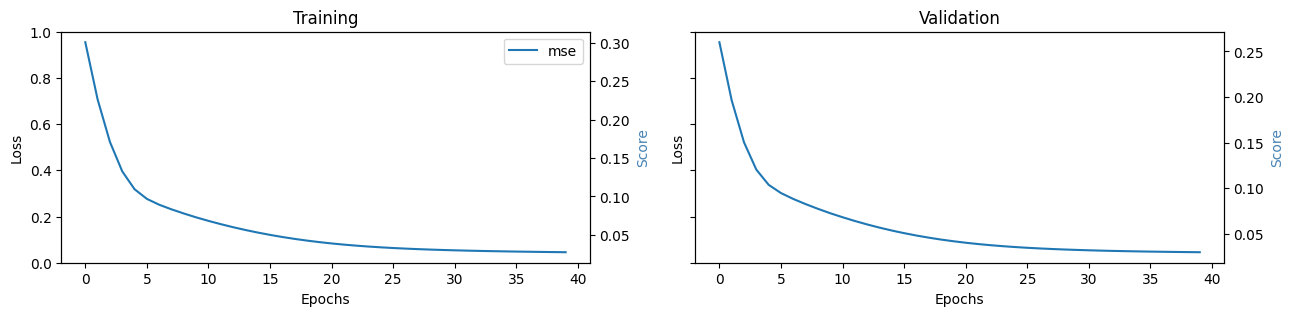

In [ ]:
utils_plot_keras_training(training)

In [ ]:
model.save('last_good_ambiance_for_real_40')

In [ ]:
def desing_test_based(cust_id,taste_products_df):
  taste_products_df2= copy.deepcopy(taste_products_df)
  row = ambiance_context_df.loc[cust_id].iloc[0]
  row["customer_id"]=cust_id
  new_df = pd.DataFrame([row]).pivot_table(index="customer_id")
  duplicated_rows = pd.concat([new_df]*500)
  duplicated_rows.reset_index(inplace=True)
  duplicated_rows['restaurant_id'] = duplicated_rows.index
  duplicated_rows=duplicated_rows.set_index(["customer_id","restaurant_id"])
  test=  duplicated_rows.add_suffix('_context').join(taste_products_df2, on=['restaurant_id'])
  return test
test = desing_test_based(11,ambiance_products_df)
test.reset_index(inplace=True)
test

<ipython-input-209-bca61d1e6eb0>:5: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  new_df = pd.DataFrame([row]).pivot_table(index="customer_id")


,customer_id,restaurant_id,Businessman_context,CasualDining_context,Cinema_context,Clasic_context,Cozy_context,Date_context,ESport_context,Elegant_context,...,ESport,Sport,FineDining,Elegant,FamilyFriendly,CasualDining,Ethnic,Cozy,Romantic,Lively
0,11,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,11,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,11,2,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,11,3,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,11,4,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,11,495,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
496,11,496,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
497,11,497,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
498,11,498,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
restaurant_df.iloc[260]

restaurant_id                                              260
flavors                               sousage|truffle|wine|bbq
profile                                 SportsPerson|Traveller
ambiance                      FineDining|FamilyFriendly|Ethnic
cuisine                                                 Steaks
reason_of_visit_restaurant                                Date
Name: 260, dtype: object

In [ ]:
customer_df.iloc[20]

customer_id                                                        20
interest_preference                                             Music
ambience_preference       Lively|Cozy|CasualDining|FineDining|Elegant
cuisine_preference                            Korean|IceCream|African
flavor_preference      rice|spicy|icecream|fruit|chocolate|meat|curry
budget_customer                                                     3
Name: 20, dtype: object

In [ ]:
utils_plot_keras_training(training)

# Overall Matching

In [ ]:
def pick_users_products_df(merged_df):
  dtf_users=merged_df[['customer_id',	'restaurant_id','reason_of_visit',"budget_customer",	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference','overall_rating' ]].groupby(['customer_id',"budget_customer"	,'restaurant_id','reason_of_visit',	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference'], as_index=False)['overall_rating'].mean()
  dtf_products= merged_df[[	'restaurant_id','profile','ambiance','reason_of_visit_restaurant','cuisine','budget' ]].set_index("restaurant_id")
  return dtf_users,dtf_products

dtf_users_general,dtf_products_general=pick_users_products_df(merged_df)
dtf_users = dtf_users_general.rename(columns={"overall_rating":"y"})

context_df = dtf_users_general[['customer_id',"budget_customer",	'restaurant_id','reason_of_visit',	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference' ]]
context_df=context_df.sort_values('customer_id').set_index(["customer_id","restaurant_id"])


In [ ]:
import copy
def taste_matching_products(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["cuisine"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags

  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["cuisine"].apply(lambda x: 1 if col == x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products
products_df_cu = taste_matching_products(restaurant_df)
products_df_cu= products_df_cu.set_index("restaurant_id").drop("flavors",axis=1).drop("profile",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1)
products_df_cu


def taste_matching_products_flavors(res):
  res2=copy.deepcopy(res)
  tags = [i.split("|") for i in res["flavors"].unique()]
  print(tags)
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      res2[col] = res2["flavors"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_fla = taste_matching_products_flavors(restaurant_df)
products_df_fla= products_df_fla.set_index("restaurant_id")
products_df_fla= products_df_fla.drop("cuisine",axis=1).drop("budget",axis=1).drop("flavors",axis=1).drop("profile",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1)


def ambiance_matching_products_reason_of_visit_restaurant(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["reason_of_visit_restaurant"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["reason_of_visit_restaurant"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_rov = ambiance_matching_products_reason_of_visit_restaurant(restaurant_df)
products_df_rov= products_df_rov.set_index("restaurant_id").drop("budget",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)



def ambiance_matching_products_profile(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["profile"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["profile"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_pro = ambiance_matching_products_profile(restaurant_df)
products_df_pro= products_df_pro.set_index("restaurant_id").drop("budget",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)
products_df_pro=products_df_pro.rename(columns = {'Family':'Family_profile'})


def ambiance_matching_products_ambiance(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["ambiance"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags

  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["ambiance"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_amb = ambiance_matching_products_ambiance(restaurant_df)
products_df_amb= products_df_amb.set_index("restaurant_id").drop("budget",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)

ambiance_products_df= products_df_rov.join(products_df_pro, on='restaurant_id')
ambiance_products_df=ambiance_products_df.join(products_df_amb, on='restaurant_id')
ambiance_products_df

taste_products_df= products_df_cu.join(products_df_fla, on="restaurant_id")
taste_products_df


final_products_df = taste_products_df.join(ambiance_products_df, on="restaurant_id")
final_products_df

[['patato', 'burrito', 'vegetable', 'grill'], ['truffle', 'chocolate', 'soup'], ['fry', 'snack', 'burger'], ['meat', 'bread', 'curry'], ['boiled', 'tapas', 'kebab', 'spicy'], ['juice', 'sweet', 'cake', 'cofee'], ['souce', 'smoothie', 'salad'], ['grill', 'bread', 'fermented'], ['vegetable', 'oil', 'pasta'], ['souce', 'pizza', 'sweet', 'sandwich'], ['spicy', 'aromatic', 'noodle'], ['vegetable', 'fresh', 'tapas'], ['tofu', 'vegeterian', 'cheese'], ['tapas', 'oil', 'tomato', 'bbq'], ['fermented', 'spicy', 'chicken', 'rice'], ['cheese', 'vegeterian', 'tofu', 'salad'], ['cake', 'bread', 'smoothie'], ['tofu', 'cake', 'cheese'], ['burger', 'aromatic', 'pizza'], ['patato', 'sousage', 'chicken'], ['cocktail', 'sweet', 'waffle'], ['spicy', 'seafood', 'tomato'], ['salty', 'cofee', 'bread', 'juice'], ['sousage', 'patato', 'chicken', 'boiled'], ['burrito', 'patato', 'modern', 'salsa'], ['boiled', 'oil', 'fish', 'tomato'], ['tempura', 'fresh', 'aromatic'], ['souce', 'pizza', 'tapas'], ['modern', 'tap

,budget,cuisine,Seafood,Sandwiches,International,Coffee,Steaks,Burgers,Asian,Cafeteria,...,SportsPerson,FineDining,Sport,CasualDining,Cozy,Lively,Ethnic,Elegant,FamilyFriendly,Romantic
restaurant_id,,,,,,,,,,,,,,,,,,,,,
0,3,LatinAmerican,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
1,2,French,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,3,Burgers,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,2,African,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,2,Turkish,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,Contemporary,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
496,2,Juice,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
497,2,Burgers,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
def prepare_users_for_collobrative_filtering(dtf_users,dtf_products):
  tmp = copy.deepcopy(dtf_users)
  dtf_users = tmp.pivot_table(index="customer_id", columns="restaurant_id", values="y")
  missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
  for col in missing_cols:
      dtf_users[col] = np.nan
  dtf_users = dtf_users[sorted(dtf_users.columns)]
  dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), columns=dtf_users.columns, index=dtf_users.index)
  return dtf_users
users_df = prepare_users_for_collobrative_filtering(dtf_users,final_products_df)


In [ ]:
def prepare_context(dtf_context):
  dtf_context_=copy.deepcopy(dtf_context)

  tags = [i.split("|") for i in context_df["ambience_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))

  for col in columns:
      dtf_context_[col] = context_df["ambience_preference"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in context_df["reason_of_visit"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      dtf_context_[col] = context_df["reason_of_visit"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in context_df["interest_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      rename_col = col
      if col == "Family":
        rename_col = "Family_profile"
      dtf_context_[rename_col] = context_df["interest_preference"].apply(lambda x: 1 if col in x else 0)


  tags = [i.split("|") for i in dtf_context["cuisine_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))

  for col in columns:
      dtf_context_[col] = dtf_context["cuisine_preference"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in dtf_context["flavor_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
  dtf_context_3= dtf_context_
  dtf_context_3=dtf_context_3.drop(['reason_of_visit','ambience_preference','interest_preference','cuisine_preference','flavor_preference'], axis=1)
  return dtf_context_3


context_df= prepare_context(context_df)



<ipython-input-15-d11a3dfdbbba>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-15-d11a3dfdbbba>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-15-d11a3dfdbbba>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [ ]:
dtf_train = dtf_train
dtf_train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
dtf_train=dtf_train.set_index(["customer_id","restaurant_id"])
## add features
joined_df = dtf_train.join(final_products_df, on='restaurant_id')
## add context
final_df = joined_df.join(context_df.add_suffix('_context'), on=['customer_id', 'restaurant_id'])
train = final_df
train

y  budget        cuisine  Seafood  \
customer_id restaurant_id                                             
0           12             0.888889       3     Vegetarian        0   
            41             0.787879       3        Italian        0   
            144            0.657895       1  LatinAmerican        0   
            168            0.580645       3         Korean        0   
            268            0.823529       3        African        0   
...                             ...     ...            ...      ...   
34999       370            0.947203       1     Vegetarian        0   
            388            0.906838       1       American        0   
            401            0.893939       3  International        0   
            440            0.843750       3         French        0   
            453            0.862069       2        Mexican        0   

                           Sandwiches  International  Coffee  Steaks  Burgers  \
customer_id restaurant_id                                                       
0           12                      0              0       0       0        0   
            41                      0              0       0       0        0   
            144                     0              0       0       0        0   
            168                     0              0       0       0        0   
            268                     0              0       0       0        0   
...                               ...            ...     ...     ...      ...   
34999       370                     0              0       0       0        0   
            388                     0              0       0       0        0   
            401                     0              1       0       0        0   
            440                     0              0       0       0        0   
            453                     0              0       0       0        0   

                           Asian  ...  vegeterian_context  smoothie_context  \
customer_id restaurant_id         ...                                         
0           12                 0  ...                   0                 0   
            41                 0  ...                   0                 0   
            144                0  ...                   0                 0   
            168                0  ...                   0                 0   
            268                0  ...                   0                 0   
...                          ...  ...                 ...               ...   
34999       370                0  ...                   1                 0   
            388                0  ...                   1                 0   
            401                0  ...                   1                 0   
            440                0  ...                   1                 0   
            453                0  ...                   1                 0   

                           mustard_context  bbq_context  kebab_context  \
customer_id restaurant_id                                                
0           12                           0            0              0   
            41                           0            0              0   
            144                          0            0              0   
            168                          0            0              0   
            268                          0            0              0   
...                                    ...          ...            ...   
34999       370                          0            0              0   
            388                          0            0              0   
            401                          0            0              0   
            440                          0            0              0   
            453                          0            0              0   

                           pizza_context  sushi_context  noodle_c

In [ ]:
features =  [
 'FastFood',
 'Coffee',
 'French',
 'Bakery',
 'Cafeteria',
 'Dutch',
 'Steaks',
 'Bar',
 'Sandwiches',
 'BarPubBrewery',
 'Burgers',
 'Seafood',
 'Asian',
 'LatinAmerican',
 'Juice',
 'Korean',
 'Greek',
 'Japanese',
 'Chinese',
 'Wine',
 'IceCream',
 'African',
 'American',
 'Vegetarian',
 'Contemporary',
 'Turkish',
 'Italian',
 'International',
 'Pizzeria',
 'Mexican',
 'wrap',
 'snacks',
 'boiled',
 'fresh',
 'sousage',
 'seafood',
 'risotto',
 'herbs',
 'mcncheese',
 'bread',
 'truffle',
 'salsa',
 'vegeterian',
 'fusion',
 'cake',
 'fish',
 'curry',
 'panini',
 'ramen',
 'tempura',
 'sandwich',
 'oil',
 'smoothie',
 'vegetable',
 'tapas',
 'cheese',
 'burger',
 'cocktail',
 'burrito',
 'chocolate',
 'stew',
 'doner',
 'bbq',
 'crab',
 'pizza',
 'wine',
 'meat',
 'noodle',
 'salty',
 'tea',
 'salad',
 'pubfood',
 'fermented',
 'pastry',
 'eclectic',
 'cofee',
 'fry',
 'fruit',
 'smoke',
 'sweet',
 'indigenous',
 'chicken',
 'snack',
 'spicy',
 'juice',
 'pasta',
 'aromatic',
 'global',
 'grill',
 'souce',
 'tex_mex',
 'taco',
 'waffle',
 'rice',
 'icecream',
 'beer',
 'tofu',
 'modern',
 'kimchi',
 'shrimp',
 'soup',
 'kebab',
 'patato',
 'sushi',
 'tomato',
 'charcuterie',
 'Guest',
 'Friend',
 'Work',
 'Date',
 'Family',
 'Family_profile',
 'Traveller',
 'Experiments',
 'Foodie',
 'Cinema',
 'Student',
 'SportsPerson',
 'StandUp',
 'Music',
 'Theatre',
 'Clasic',
 'Reading',
 'Businessman',
 'Hectic',
 'ESport',
 'Cozy',
 'Elegant',
 'CasualDining',
 'FineDining',
 'Ethnic',
 'Lively',
 'Sport',
 'FamilyFriendly',
 'Romantic']


context= ['Cozy_context',
 'Elegant_context',
 'CasualDining_context',
 'FineDining_context',
 'Ethnic_context',
 'Lively_context',
 'Sport_context',
 'FamilyFriendly_context',
 'Romantic_context',
 'Guest_context',
 'Friend_context',
 'Work_context',
 'Date_context',
 'Family_context',
 'Traveller_context',
 'Experiments_context',
 'Foodie_context',
 'Cinema_context',
 'Student_context',
 'SportsPerson_context',
 'StandUp_context',
 'Music_context',
 'Theatre_context',
 'Businessman_context',
 'Clasic_context',
 'Reading_context',
 'Family_profile_context',
 'Hectic_context',
 'ESport_context',
 'FastFood_context',
 'Coffee_context',
 'French_context',
 'Cafeteria_context',
 'Bakery_context',
 'Dutch_context',
 'Steaks_context',
 'Bar_context',
 'Sandwiches_context',
 'BarPubBrewery_context',
 'Burgers_context',
 'Seafood_context',
 'Asian_context',
 'LatinAmerican_context',
 'Juice_context',
 'Korean_context',
 'Greek_context',
 'Japanese_context',
 'Chinese_context',
 'Wine_context',
 'IceCream_context',
 'African_context',
 'American_context',
 'Vegetarian_context',
 'Contemporary_context',
 'Turkish_context',
 'Italian_context',
 'International_context',
 'Pizzeria_context',
 'Mexican_context',
 'boiled_context',
 'mcncheese_context',
 'risotto_context',
 'seafood_context',
 'bread_context',
 'salsa_context',
 'panini_context',
 'ramen_context',
 'sandwich_context',
 'tapas_context',
 'stew_context',
 'bbq_context',
 'meat_context',
 'salty_context',
 'cofee_context',
 'fruit_context',
 'diverse_context',
 'souvlaki_context',
 'juice_context',
 'grill_context',
 'rice_context',
 'taco_context',
 'icecream_context',
 'patato_context',
 'sushi_context',
 'tomato_context',
 'eclectic_context',
 'herbs_context',
 'sousage_context',
 'truffle_context',
 'vegeterian_context',
 'fusion_context',
 'cake_context',
 'curry_context',
 'smoothie_context',
 'crab_context',
 'pizza_context',
 'salad_context',
 'fry_context',
 'smoke_context',
 'waffle_context',
 'tofu_context',
 'mustard_context',
 'shrimp_context',
 'kebab_context',
 'wrap_context',
 'fresh_context',
 'baklava_context',
 'tempura_context',
 'world_context',
 'burrito_context',
 'chocolate_context',
 'cheese_context',
 'doner_context',
 'noodle_context',
 'tea_context',
 'fermented_context',
 'chicken_context',
 'snack_context',
 'spicy_context',
 'aromatic_context',
 'global_context',
 'souce_context',
 'beer_context',
 'modern_context',
 'soup_context',
 'tex_mex_context',
 'charcuterie_context',
 'feta_context',
 'snacks_context',
 'fish_context',
 'oil_context',
 'cocktail_context',
 'vegetable_context',
 'burger_context',
 'wine_context',
 'pubfood_context',
 'pastry_context',
 'umami_context',
 'sweet_context',
 'indigenous_context',
 'pasta_context',
 'kimchi_context']


In [ ]:
users_df.shape

(35000, 500)

In [ ]:
import keras
embeddings_size = 64
usr, prd = users_df.shape[0], users_df.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)


# Compile
model_gen = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
optimizer = keras.optimizers.Adam(lr=0.000001)
model_gen.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
model_gen.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 64)        2240000     ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 64)        32000       ['xproducts_in[0][0]']           
                                                                                       

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [ ]:
train=train.reset_index()


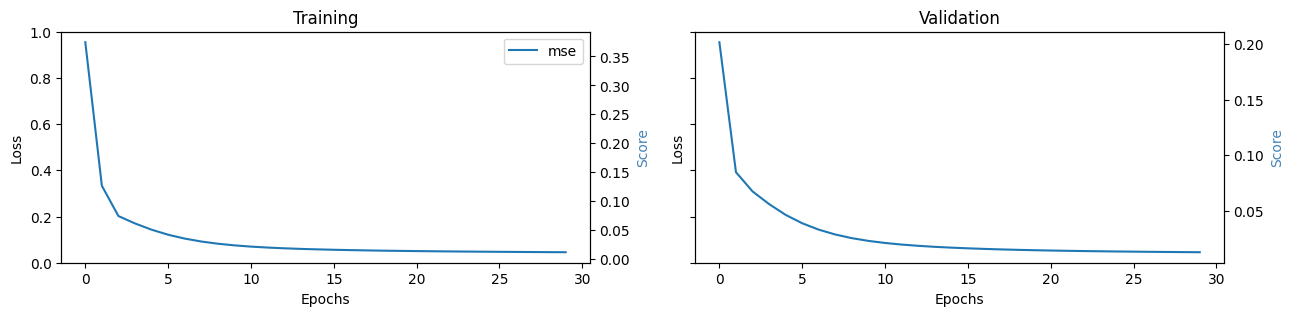

In [ ]:
# train
training = model_gen.fit(x=[train["customer_id"], train["restaurant_id"], train[features], train[context]], y=train["y"],
                     epochs=30, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model_gen = training.model
utils_plot_keras_training(training)

In [ ]:
model_gen.save('last_good_over_for_real')

In [ ]:
import collections
from tensorflow.keras.models import load_model
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple
## for machine learning
from sklearn import metrics, preprocessing
## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import copy

np.random.seed(42)

In [ ]:
products_df

NameError: ignored

# for back-end



In [ ]:
import collections
from tensorflow.keras.models import load_model
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple
## for machine learning
from sklearn import metrics, preprocessing
## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import copy
np.random.seed(42)

def create_customer_df(path):
  cust = pd.read_csv(path)
  columns_to_vectorize = ['interest_preference', 'ambience_preference', 'cuisine_preference', 'flavor_preference']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs.append(cust['customer_id'])
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = cust[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)
  vectorized_dfs.append(cust['budget_customer'])

  result_cus = pd.concat(vectorized_dfs, axis=1)
  return result_cus
def create_review_df(path):
  rev = pd.read_csv('rev.csv')
  columns_to_vectorize = ['customer_need_fast_slow']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs= [rev['id_review'],rev['customer_id'],rev['restaurant_id'],rev['taste_rating'],rev["ambiance_rating"],rev['overall_rating'],rev['reason_of_visit']]
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = rev[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)

  result_rev = pd.concat(vectorized_dfs, axis=1)
  return result_rev

def merge_dataframes(review_df,customer_df,restaurant_df):
  merged_df = pd.merge(review_df, customer_df, on='customer_id')
  merged_df = pd.merge(merged_df, restaurant_df, on='restaurant_id')
  return merged_df

#alternative
def create_restaurant_df(path):
  res = pd.read_csv(path)
  columns_to_vectorize = ['flavors','profile','ambiance','cuisine','reason_of_visit_restaurant']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs= [res['restaurant_id'],res['budget']]
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = res[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)

  result_rev = pd.concat(vectorized_dfs, axis=1)
  return result_rev

customer_df=create_customer_df('cus.csv')
review_df=create_review_df('rev.csv')
restaurant_df=create_restaurant_df('res.csv').sort_values("restaurant_id")
merged_df=merge_dataframes(review_df,customer_df,restaurant_df)
merged_df=merged_df.sort_values("customer_id")

def pick_users_products_df(merged_df):
  dtf_users=merged_df[['customer_id',	'restaurant_id','reason_of_visit',"budget_customer",	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference','overall_rating' ]].groupby(['customer_id',"budget_customer"	,'restaurant_id','reason_of_visit',	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference'], as_index=False)['overall_rating'].mean()
  dtf_products= merged_df[[	'restaurant_id','profile','ambiance','reason_of_visit_restaurant','cuisine','budget' ]].set_index("restaurant_id")
  return dtf_users,dtf_products

dtf_users_general,dtf_products_general=pick_users_products_df(merged_df)
dtf_users = dtf_users_general.rename(columns={"overall_rating":"y"})

context_df = dtf_users_general[['customer_id',"budget_customer",	'restaurant_id','reason_of_visit',	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference' ]]
context_df=context_df.sort_values('customer_id').set_index(["customer_id","restaurant_id"])

import copy
def taste_matching_products(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["cuisine"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags

  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["cuisine"].apply(lambda x: 1 if col == x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products
products_df_cu = taste_matching_products(restaurant_df)
products_df_cu= products_df_cu.set_index("restaurant_id").drop("flavors",axis=1).drop("profile",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1)
products_df_cu


def taste_matching_products_flavors(res):
  res2=copy.deepcopy(res)
  tags = [i.split("|") for i in res["flavors"].unique()]
  print(tags)
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      res2[col] = res2["flavors"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_fla = taste_matching_products_flavors(restaurant_df)
products_df_fla= products_df_fla.set_index("restaurant_id")
products_df_fla= products_df_fla.drop("cuisine",axis=1).drop("budget",axis=1).drop("flavors",axis=1).drop("profile",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1)


def ambiance_matching_products_reason_of_visit_restaurant(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["reason_of_visit_restaurant"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["reason_of_visit_restaurant"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_rov = ambiance_matching_products_reason_of_visit_restaurant(restaurant_df)
products_df_rov= products_df_rov.set_index("restaurant_id").drop("budget",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)



def ambiance_matching_products_profile(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["profile"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["profile"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_pro = ambiance_matching_products_profile(restaurant_df)
products_df_pro= products_df_pro.set_index("restaurant_id").drop("budget",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)
products_df_pro=products_df_pro.rename(columns = {'Family':'Family_profile'})


def ambiance_matching_products_ambiance(res):
  res2= copy.deepcopy(res)
  tags = [i.split("|") for i in res["ambiance"].unique()]
  modi_tags = [[tag[0].replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")] for tag in tags]
  tags=modi_tags

  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
    colname=col
    res2[colname] = res2["ambiance"].apply(lambda x: 1 if col in x else 0)
  dtf_products=res2
  dtf_products.set_index("restaurant_id")
  return dtf_products

products_df_amb = ambiance_matching_products_ambiance(restaurant_df)
products_df_amb= products_df_amb.set_index("restaurant_id").drop("budget",axis=1).drop("ambiance",axis=1).drop("reason_of_visit_restaurant",axis=1).drop("cuisine",axis=1).drop("profile",axis=1).drop("flavors",axis=1)

ambiance_products_df= products_df_rov.join(products_df_pro, on='restaurant_id')
ambiance_products_df=ambiance_products_df.join(products_df_amb, on='restaurant_id')
ambiance_products_df

taste_products_df= products_df_cu.join(products_df_fla, on="restaurant_id")
taste_products_df


final_products_df = taste_products_df.join(ambiance_products_df, on="restaurant_id")
final_products_df

def prepare_context(dtf_context):
  dtf_context_=copy.deepcopy(dtf_context)

  tags = [i.split("|") for i in context_df["ambience_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))

  for col in columns:
      dtf_context_[col] = context_df["ambience_preference"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in context_df["reason_of_visit"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      dtf_context_[col] = context_df["reason_of_visit"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in context_df["interest_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      rename_col = col
      if col == "Family":
        rename_col = "Family_profile"
      dtf_context_[rename_col] = context_df["interest_preference"].apply(lambda x: 1 if col in x else 0)


  tags = [i.split("|") for i in dtf_context["cuisine_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))

  for col in columns:
      dtf_context_[col] = dtf_context["cuisine_preference"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in dtf_context["flavor_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  for col in columns:
      dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
  dtf_context_3= dtf_context_
  dtf_context_3=dtf_context_3.drop(['reason_of_visit','ambience_preference','interest_preference','cuisine_preference','flavor_preference'], axis=1)
  return dtf_context_3


context_df= prepare_context(context_df)



features =  [
 'FastFood',
 'Coffee',
 'French',
 'Bakery',
 'Cafeteria',
 'Dutch',
 'Steaks',
 'Bar',
 'Sandwiches',
 'BarPubBrewery',
 'Burgers',
 'Seafood',
 'Asian',
 'LatinAmerican',
 'Juice',
 'Korean',
 'Greek',
 'Japanese',
 'Chinese',
 'Wine',
 'IceCream',
 'African',
 'American',
 'Vegetarian',
 'Contemporary',
 'Turkish',
 'Italian',
 'International',
 'Pizzeria',
 'Mexican',
 'wrap',
 'snacks',
 'boiled',
 'fresh',
 'sousage',
 'seafood',
 'risotto',
 'herbs',
 'mcncheese',
 'bread',
 'truffle',
 'salsa',
 'vegeterian',
 'fusion',
 'cake',
 'fish',
 'curry',
 'panini',
 'ramen',
 'tempura',
 'sandwich',
 'oil',
 'smoothie',
 'vegetable',
 'tapas',
 'cheese',
 'burger',
 'cocktail',
 'burrito',
 'chocolate',
 'stew',
 'doner',
 'bbq',
 'crab',
 'pizza',
 'wine',
 'meat',
 'noodle',
 'salty',
 'tea',
 'salad',
 'pubfood',
 'fermented',
 'pastry',
 'eclectic',
 'cofee',
 'fry',
 'fruit',
 'smoke',
 'sweet',
 'indigenous',
 'chicken',
 'snack',
 'spicy',
 'juice',
 'pasta',
 'aromatic',
 'global',
 'grill',
 'souce',
 'tex_mex',
 'taco',
 'waffle',
 'rice',
 'icecream',
 'beer',
 'tofu',
 'modern',
 'kimchi',
 'shrimp',
 'soup',
 'kebab',
 'patato',
 'sushi',
 'tomato',
 'charcuterie',
 'Guest',
 'Friend',
 'Work',
 'Date',
 'Family',
 'Family_profile',
 'Traveller',
 'Experiments',
 'Foodie',
 'Cinema',
 'Student',
 'SportsPerson',
 'StandUp',
 'Music',
 'Theatre',
 'Clasic',
 'Reading',
 'Businessman',
 'Hectic',
 'ESport',
 'Cozy',
 'Elegant',
 'CasualDining',
 'FineDining',
 'Ethnic',
 'Lively',
 'Sport',
 'FamilyFriendly',
 'Romantic']


context= ['Cozy_context',
 'Elegant_context',
 'CasualDining_context',
 'FineDining_context',
 'Ethnic_context',
 'Lively_context',
 'Sport_context',
 'FamilyFriendly_context',
 'Romantic_context',
 'Guest_context',
 'Friend_context',
 'Work_context',
 'Date_context',
 'Family_context',
 'Traveller_context',
 'Experiments_context',
 'Foodie_context',
 'Cinema_context',
 'Student_context',
 'SportsPerson_context',
 'StandUp_context',
 'Music_context',
 'Theatre_context',
 'Businessman_context',
 'Clasic_context',
 'Reading_context',
 'Family_profile_context',
 'Hectic_context',
 'ESport_context',
 'FastFood_context',
 'Coffee_context',
 'French_context',
 'Cafeteria_context',
 'Bakery_context',
 'Dutch_context',
 'Steaks_context',
 'Bar_context',
 'Sandwiches_context',
 'BarPubBrewery_context',
 'Burgers_context',
 'Seafood_context',
 'Asian_context',
 'LatinAmerican_context',
 'Juice_context',
 'Korean_context',
 'Greek_context',
 'Japanese_context',
 'Chinese_context',
 'Wine_context',
 'IceCream_context',
 'African_context',
 'American_context',
 'Vegetarian_context',
 'Contemporary_context',
 'Turkish_context',
 'Italian_context',
 'International_context',
 'Pizzeria_context',
 'Mexican_context',
 'boiled_context',
 'mcncheese_context',
 'risotto_context',
 'seafood_context',
 'bread_context',
 'salsa_context',
 'panini_context',
 'ramen_context',
 'sandwich_context',
 'tapas_context',
 'stew_context',
 'bbq_context',
 'meat_context',
 'salty_context',
 'cofee_context',
 'fruit_context',
 'diverse_context',
 'souvlaki_context',
 'juice_context',
 'grill_context',
 'rice_context',
 'taco_context',
 'icecream_context',
 'patato_context',
 'sushi_context',
 'tomato_context',
 'eclectic_context',
 'herbs_context',
 'sousage_context',
 'truffle_context',
 'vegeterian_context',
 'fusion_context',
 'cake_context',
 'curry_context',
 'smoothie_context',
 'crab_context',
 'pizza_context',
 'salad_context',
 'fry_context',
 'smoke_context',
 'waffle_context',
 'tofu_context',
 'mustard_context',
 'shrimp_context',
 'kebab_context',
 'wrap_context',
 'fresh_context',
 'baklava_context',
 'tempura_context',
 'world_context',
 'burrito_context',
 'chocolate_context',
 'cheese_context',
 'doner_context',
 'noodle_context',
 'tea_context',
 'fermented_context',
 'chicken_context',
 'snack_context',
 'spicy_context',
 'aromatic_context',
 'global_context',
 'souce_context',
 'beer_context',
 'modern_context',
 'soup_context',
 'tex_mex_context',
 'charcuterie_context',
 'feta_context',
 'snacks_context',
 'fish_context',
 'oil_context',
 'cocktail_context',
 'vegetable_context',
 'burger_context',
 'wine_context',
 'pubfood_context',
 'pastry_context',
 'umami_context',
 'sweet_context',
 'indigenous_context',
 'pasta_context',
 'kimchi_context']

# Extra data
features_ambiance = ['Work',
 'Date',
 'Guest',
 'Friend',
 'Family',
 'Reading',
 'ESport',
 'Student',
 'Music',
 'Experiments',
 'Theatre',
 'StandUp',
 'Businessman',
 'Clasic',
 'SportsPerson',
 'Cinema',
 'Foodie',
 'Traveller',
 'Hectic',
 'Family_profile',
 'CasualDining',
 'Ethnic',
 'FamilyFriendly',
 'Elegant',
 'Cozy',
 'FineDining',
 'Sport',
 'Romantic',
 'Lively']

context_ambiance =['CasualDining_context',
 'Ethnic_context',
 'FamilyFriendly_context',
 'Elegant_context',
 'Cozy_context',
 'FineDining_context',
 'Sport_context',
 'Romantic_context',
 'Lively_context',
 'Work_context',
 'Date_context',
 'Guest_context',
 'Friend_context',
 'Family_context',
 'ESport_context',
 'Reading_context',
 'Student_context',
 'Music_context',
 'Experiments_context',
 'StandUp_context',
 'Theatre_context',
 'Businessman_context',
 'SportsPerson_context',
 'Clasic_context',
 'Cinema_context',
 'Foodie_context',
 'Traveller_context',
 'Hectic_context',
 'Family_profile_context']
features_taste = ['salsa',
 'curry',
 'noodle',
 'soup',
 'herbs',
 'aromatic',
 'stew',
 'wrap',
 'tempura',
 'meat',
 'waffle',
 'fresh',
 'snacks',
 'tex_mex',
 'cheese',
 'vegeterian',
 'truffle',
 'bread',
 'risotto',
 'pasta',
 'sandwich',
 'tomato',
 'seafood',
 'doner',
 'burger',
 'juice',
 'beer',
 'charcuterie',
 'modern',
 'tofu',
 'patato',
 'fish',
 'sushi',
 'salad',
 'burrito',
 'pastry',
 'bbq',
 'fry',
 'chocolate',
 'taco',
 'tapas',
 'kebab',
 'smoke',
 'oil',
 'spicy',
 'grill',
 'cofee',
 'kimchi',
 'wine',
 'global',
 'snack',
 'tea',
 'shrimp',
 'fusion',
 'mcncheese',
 'sousage',
 'pizza',
 'fruit',
 'chicken',
 'smoothie',
 'souce',
 'fermented',
 'indigenous',
 'rice',
 'sweet',
 'panini',
 'boiled',
 'pubfood',
 'cocktail',
 'crab',
 'vegetable',
 'salty',
 'eclectic',
 'cake',
 'icecream',
 'ramen',
 'Asian',
 'Vegetarian',
 'Japanese',
 'Mexican',
 'Wine',
 'Greek',
 'Coffee',
 'Burgers',
 'Pizzeria',
 'Contemporary',
 'Bar',
 'LatinAmerican',
 'Chinese',
 'Seafood',
 'Italian',
 'Korean',
 'Cafeteria',
 'Juice',
 'Dutch',
 'FastFood',
 'Bakery',
 'American',
 'French',
 'Turkish',
 'African',
 'Sandwiches',
 'IceCream',
 'International',
 'BarPubBrewery',
 'Steaks']


context_taste = ['Asian_context',
 'Vegetarian_context',
 'Japanese_context',
 'Mexican_context',
 'Wine_context',
 'Greek_context',
 'Coffee_context',
 'Burgers_context',
 'Pizzeria_context',
 'Contemporary_context',
 'Bar_context',
 'LatinAmerican_context',
 'Chinese_context',
 'Korean_context',
 'Italian_context',
 'Seafood_context',
 'Cafeteria_context',
 'Juice_context',
 'Dutch_context',
 'FastFood_context',
 'Bakery_context',
 'American_context',
 'French_context',
 'Turkish_context',
 'African_context',
 'IceCream_context',
 'International_context',
 'BarPubBrewery_context',
 'Sandwiches_context',
 'Steaks_context',
 'noodle_context',
 'soup_context',
 'meat_context',
 'fresh_context',
 'snacks_context',
 'mustard_context',
 'seafood_context',
 'burger_context',
 'beer_context',
 'juice_context',
 'fish_context',
 'smoke_context',
 'mcncheese_context',
 'snack_context',
 'shrimp_context',
 'fruit_context',
 'pubfood_context',
 'cocktail_context',
 'indigenous_context',
 'diverse_context',
 'wrap_context',
 'cheese_context',
 'sushi_context',
 'salad_context',
 'burrito_context',
 'kebab_context',
 'souvlaki_context',
 'grill_context',
 'cofee_context',
 'kimchi_context',
 'fermented_context',
 'baklava_context',
 'cake_context',
 'ramen_context',
 'salsa_context',
 'aromatic_context',
 'stew_context',
 'tempura_context',
 'waffle_context',
 'tex_mex_context',
 'truffle_context',
 'bread_context',
 'pasta_context',
 'sandwich_context',
 'tomato_context',
 'umami_context',
 'world_context',
 'doner_context',
 'charcuterie_context',
 'modern_context',
 'tofu_context',
 'pastry_context',
 'chocolate_context',
 'oil_context',
 'tapas_context',
 'wine_context',
 'global_context',
 'fusion_context',
 'sousage_context',
 'chicken_context',
 'smoothie_context',
 'sweet_context',
 'panini_context',
 'boiled_context',
 'crab_context',
 'vegetable_context',
 'eclectic_context',
 'curry_context',
 'herbs_context',
 'vegeterian_context',
 'risotto_context',
 'patato_context',
 'bbq_context',
 'fry_context',
 'taco_context',
 'spicy_context',
 'tea_context',
 'pizza_context',
 'feta_context',
 'souce_context',
 'rice_context',
 'salty_context',
 'icecream_context']

[['patato', 'burrito', 'vegetable', 'grill'], ['truffle', 'chocolate', 'soup'], ['fry', 'snack', 'burger'], ['meat', 'bread', 'curry'], ['boiled', 'tapas', 'kebab', 'spicy'], ['juice', 'sweet', 'cake', 'cofee'], ['souce', 'smoothie', 'salad'], ['grill', 'bread', 'fermented'], ['vegetable', 'oil', 'pasta'], ['souce', 'pizza', 'sweet', 'sandwich'], ['spicy', 'aromatic', 'noodle'], ['vegetable', 'fresh', 'tapas'], ['tofu', 'vegeterian', 'cheese'], ['tapas', 'oil', 'tomato', 'bbq'], ['fermented', 'spicy', 'chicken', 'rice'], ['cheese', 'vegeterian', 'tofu', 'salad'], ['cake', 'bread', 'smoothie'], ['tofu', 'cake', 'cheese'], ['burger', 'aromatic', 'pizza'], ['patato', 'sousage', 'chicken'], ['cocktail', 'sweet', 'waffle'], ['spicy', 'seafood', 'tomato'], ['salty', 'cofee', 'bread', 'juice'], ['sousage', 'patato', 'chicken', 'boiled'], ['burrito', 'patato', 'modern', 'salsa'], ['boiled', 'oil', 'fish', 'tomato'], ['tempura', 'fresh', 'aromatic'], ['souce', 'pizza', 'tapas'], ['modern', 'tap

<ipython-input-3-f364f4000a64>:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-3-f364f4000a64>:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-3-f364f4000a64>:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [ ]:
all_cuisines =  [ 'FastFood',
 'Coffee',
 'French',
 'Bakery',
 'Cafeteria',
 'Dutch',
 'Steaks',
 'Bar',
 'Sandwiches',
 'BarPubBrewery',
 'Burgers',
 'Seafood',
 'Asian',
 'LatinAmerican',
 'Juice',
 'Korean',
 'Greek',
 'Japanese',
 'Chinese',
 'Wine',
 'IceCream',
 'African',
 'American',
 'Vegetarian',
 'Contemporary',
 'Turkish',
 'Italian',
 'International',
 'Pizzeria',
 'Mexican']

In [ ]:
region,budget_amount,cust_id,topk=1,3,78,10
info_cust=context_df.loc[cust_id].iloc[0]

def desing_test_based(region,budget_amount,cust_id,products_df,raw_context,restaurant_ids,lengt_of_ids):
  # create a new dataframe with just that row
  products_df2= copy.deepcopy(products_df)
  row = raw_context
  row["customer_id"]=cust_id
  new_df = pd.DataFrame([row]).pivot_table(index="customer_id")
  duplicated_rows = pd.concat([new_df]*lengt_of_ids)
  duplicated_rows.reset_index(inplace=True)
  duplicated_rows['restaurant_id'] = restaurant_ids
  duplicated_rows=duplicated_rows.set_index(["customer_id","restaurant_id"])
  test=  duplicated_rows.add_suffix('_context').join(products_df2, on=['restaurant_id'])
  test=test.reset_index()
  test=test[test["budget"]<=budget_amount]
  test=test[test["restaurant_id"]%region==0 ]
  return test

desing_test_based(region,budget_amount,cust_id,final_products_df,info_cust,[2,4],2)

,customer_id,restaurant_id,African_context,American_context,Asian_context,Bakery_context,Bar_context,BarPubBrewery_context,Burgers_context,Businessman_context,...,Cinema,Cozy,Elegant,FineDining,Sport,Romantic,CasualDining,Lively,Ethnic,FamilyFriendly
0,78,2,0,1,0,0,0,0,0,1,...,1,0,1,0,0,0,1,0,1,0
1,78,4,0,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,1,0,1


# keep


In [ ]:
def desing_test_based(region,budget_amount,cust_id,products_df,raw_context):
  # create a new dataframe with just that row
  products_df2= copy.deepcopy(products_df)
  row = raw_context
  row["customer_id"]=cust_id
  new_df = pd.DataFrame([row]).pivot_table(index="customer_id")
  duplicated_rows = pd.concat([new_df]*500)
  duplicated_rows.reset_index(inplace=True)
  duplicated_rows['restaurant_id'] = duplicated_rows.index
  duplicated_rows=duplicated_rows.set_index(["customer_id","restaurant_id"])
  test=  duplicated_rows.add_suffix('_context').join(products_df2, on=['restaurant_id'])
  test=test.reset_index()
  test=test[test["budget"]<=budget_amount]
  test=test[test["restaurant_id"]%region==0 ]
  return test

def give_me_ratings_of_overall(list_of_df_top_5, context_taste, taste_model,features_taste):
  to_append=[]
  for i in range(len(list_of_df_top_5)):
      if (len(list_of_df_top_5[i])!=0):
        prod_to_predict =copy.deepcopy(list_of_df_top_5[i])
        prod_to_predict["yhat"] = taste_model.predict([prod_to_predict["customer_id"], prod_to_predict["restaurant_id"], prod_to_predict[features_taste], prod_to_predict[context_taste]])
        prod_to_predict = prod_to_predict.sort_values('yhat')
        to_append.append(prod_to_predict)
  return to_append


def give_me_top_k_overall_of_customer_preffered(cus,res,top_k):
  tags = []
  new_df = copy.deepcopy(pd.DataFrame([cus]).pivot_table(index="customer_id"))
  for col in new_df.columns:
    if new_df.iloc[0][col] ==1:
      if  col in (all_cuisines):
        tags.append(col)
  rrrr=[]
  for i,el in enumerate(tags) :
    if i == 0:
      rrrr.append([res["cuisine"]==el])
    else:
      rrrr.append( [res["cuisine"]==el])

  __aa=[]
  for i in range(len(tags)):
    __aa.append(res[rrrr[i][0]][ len(res[rrrr[i][0]])-top_k:len(res[rrrr[i][0]])  ])
  top_k_cuisine_preffered=__aa
  customer_cuisine_prefference = tags

  return customer_cuisine_prefference,top_k_cuisine_preffered


def give_me_top_k_general_results(res,top_k):
  __aa=[]
  __aa.append(res[   len(res)-top_k  : len(res)]  )
  top_k_cuisine_preffered_=__aa
  return top_k_cuisine_preffered_

def all_at_once(region,budget_amount,cust_id,products_df,topk,general_model,context,features,context_taste,taste_model,features_taste,raw_context,ambiance_model,ambiance_features,ambiance_context):
  test = desing_test_based(region,budget_amount,cust_id,products_df,raw_context)
  test["yhat"] = general_model.predict([test["customer_id"], test["restaurant_id"], test[features], test[context]])
  all_results = test.sort_values('yhat')
  #all_res burada overall ratingden gelen top k yhat=> overall ratingleri
  all_res =give_me_top_k_general_results(all_results,topk)
  #all_res_taste burada overall ratingden gelen top k ların taste matchi  yhat=> taste ratingleri
  all_res_taste  =give_me_ratings_of_overall(all_res, context_taste, taste_model,features_taste)
  #all_res_ambiance burada overall ratingden gelen top k ların ambiance matchi  yhat=> ambiance ratingleri

  all_res_ambiance   =give_me_ratings_of_overall(all_res, ambiance_context, ambiance_model,ambiance_features)

  #top_k_cuisine_preffered  =>>> adamin tercih ettigi cuisinelerin overall matchingi  yhat=> overall ratingleri
  customer_cuisine_prefference,top_k_cuisine_preffered = give_me_top_k_overall_of_customer_preffered(raw_context,all_results,topk)
  #taste_results_of_all_results ===>>>adamin tercih ettigi cuisinelerin taste matchingi  yhat=> taste ratingleri
  taste_results_of_all_results=give_me_ratings_of_overall(top_k_cuisine_preffered, context_taste, taste_model,features_taste)

  #ambiance_results_of_all_results ===>>>adamin tercih ettigi cuisinelerin ambiance matchingi  yhat=> ambiance ratingleri
  ambiance_results_of_all_results=give_me_ratings_of_overall(top_k_cuisine_preffered, ambiance_context, ambiance_model,ambiance_features)
  return taste_results_of_all_results,top_k_cuisine_preffered,all_results,all_res,all_res_taste,ambiance_results_of_all_results,all_res_ambiance


taste_model = load_model('last_good_taste_for_real')
general_model = load_model('last_good_over_for_real')
ambiance_model = load_model('last_good_ambiance')
region,budget_amount,cust_id,topk=1,3,78,10
info_cust=context_df.loc[cust_id].iloc[0]
taste_results_of_all_results,top_k_cuisine_preffered,all_results,all_res,all_res_taste,ambiance_results_of_all_results,all_res_ambiance = all_at_once(region,budget_amount,cust_id,final_products_df,topk,general_model,context,features,context_taste,taste_model,features_taste,info_cust,ambiance_model,features_ambiance,context_ambiance)


1/1 [==============================] - 0s 33ms/step


In [ ]:
taste_results_of_all_results[0]

,customer_id,restaurant_id,African_context,American_context,Asian_context,Bakery_context,Bar_context,BarPubBrewery_context,Burgers_context,Businessman_context,...,FineDining,Sport,CasualDining,Cozy,Lively,Ethnic,Elegant,FamilyFriendly,Romantic,yhat
420,78,420,0,1,0,0,0,0,0,1,...,0,0,1,1,0,0,1,0,0,0.728158
285,78,285,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0.729584
477,78,477,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0.745354
89,78,89,0,1,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0.749289
303,78,303,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0.758126
96,78,96,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,0.778084
206,78,206,0,1,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0.780245
49,78,49,0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0.794788
388,78,388,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0.804231
442,78,442,0,1,0,0,0,0,0,1,...,0,0,1,1,1,0,0,0,0,0.822239


In [ ]:
for col in context_df.loc[cust_id].columns:
  if context_df.loc[cust_id].iloc[0][col]==0:
    print(col)

Sport
Elegant
FamilyFriendly
Cozy
FineDining
Date
Friend
Family
Work
Clasic
Theatre
Student
Reading
ESport
Family_profile
Foodie
Hectic
Experiments
Businessman
Traveller
LatinAmerican
BarPubBrewery
Turkish
Korean
International
Asian
African
Pizzeria
Bakery
Seafood
Japanese
Chinese
Greek
IceCream
Vegetarian
Steaks
Sandwiches
Juice
Burgers
French
Dutch
Contemporary
FastFood
Coffee
Wine
American
Mexican
Italian
pastry
truffle
souce
fish
seafood
meat
ramen
kebab
stew
pizza
chicken
modern
tempura
tapas
tomato
sandwich
mcncheese
global
burrito
grill
baklava
herbs
oil
cheese
fresh
doner
diverse
spicy
mustard
cake
eclectic
snacks
rice
fusion
boiled
snack
wrap
noodle
shrimp
world
tex_mex
bbq
icecream
fermented
juice
salad
pubfood
curry
crab
sousage
sweet
vegeterian
souvlaki
feta
taco
patato
chocolate
kimchi
soup
smoothie
tofu
pasta
sushi
salsa
burger
smoke
indigenous
waffle
charcuterie
umami
tea
wine
fruit
salty
risotto
panini
aromatic
vegetable


In [ ]:
dtf_users_general[['customer_id',"budget_customer",	'restaurant_id','reason_of_visit',	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference' ]]

,customer_id,budget_customer,restaurant_id,reason_of_visit,interest_preference,ambience_preference,cuisine_preference,flavor_preference
0,0,3,12,Guest,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail
1,0,3,41,Guest,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail
2,0,3,144,Guest,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail
3,0,3,168,Friend,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail
4,0,3,268,Friend,StandUp|Music|Cinema|SportsPerson,Ethnic|CasualDining|Lively|Romantic,Bar|Cafeteria,beer|fry|bread|cofee|cocktail
...,...,...,...,...,...,...,...,...
436113,34999,1,370,Work,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...
436114,34999,1,388,Guest,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...
436115,34999,1,401,Work,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...
436116,34999,1,440,Guest,Foodie|Reading|Businessman,FineDining|Sport|Romantic|Lively,Contemporary|Sandwiches|French|Vegetarian,burger|meat|salad|sandwich|grill|truffle|herbs...


In [ ]:
context_df__=merged_df[['customer_id',	'reason_of_visit',"budget_customer",	'interest_preference',	'ambience_preference',	'cuisine_preference',	'flavor_preference']]



def prepare_context(dtf_context):
  dtf_context_=copy.deepcopy(dtf_context)
  tags = [i.split("|") for i in dtf_context["ambience_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  print(columns)
  for col in columns:
      dtf_context_[col] = dtf_context["ambience_preference"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in dtf_context["reason_of_visit"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  print(columns)
  for col in columns:
      dtf_context_[col] = dtf_context["reason_of_visit"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in dtf_context["interest_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  print(columns)
  for col in columns:
      rename_col = col
      if col == "Family":
        rename_col = "Family_profile"
      dtf_context_[rename_col] = dtf_context["interest_preference"].apply(lambda x: 1 if col in x else 0)


  tags = [i.split("|") for i in dtf_context["cuisine_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  print(columns)
  for col in columns:
      dtf_context_[col] = dtf_context["cuisine_preference"].apply(lambda x: 1 if col in x else 0)

  tags = [i.split("|") for i in dtf_context["flavor_preference"].unique()]
  columns = list(set([i for lst in tags for i in lst]))
  print(columns)
  for col in columns:
      dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
  dtf_context_3= dtf_context_
  dtf_context_3=dtf_context_3.drop(['reason_of_visit','ambience_preference','interest_preference','cuisine_preference','flavor_preference'], axis=1)
  return dtf_context_3

check_out =  prepare_context(context_df__)


['FamilyFriendly', 'Ethnic', 'Romantic', 'Lively', 'Elegant', 'Sport', 'FineDining', 'Cozy', 'CasualDining']
['Family', 'Guest', 'Work', 'Date', 'Friend']
['Foodie', 'Music', 'Traveller', 'Family', 'Hectic', 'Reading', 'Clasic', 'Student', 'Cinema', 'StandUp', 'Experiments', 'ESport', 'Theatre', 'Businessman', 'SportsPerson']
['Turkish', 'Korean', 'Japanese', 'Greek', 'Cafeteria', 'Seafood', 'Dutch', 'French', 'LatinAmerican', 'BarPubBrewery', 'Asian', 'Wine', 'American', 'Juice', 'IceCream', 'Mexican', 'Burgers', 'Sandwiches', 'Pizzeria', 'Coffee', 'Steaks', 'Italian', 'Chinese', 'African', 'International', 'Contemporary', 'FastFood', 'Bakery', 'Bar', 'Vegetarian']
['ramen', 'tomato', 'umami', 'mustard', 'mcncheese', 'spicy', 'snacks', 'pasta', 'doner', 'salsa', 'herbs', 'taco', 'waffle', 'fish', 'crab', 'snack', 'tofu', 'wrap', 'charcuterie', 'kimchi', 'icecream', 'cake', 'pastry', 'panini', 'vegetable', 'wine', 'stew', 'juice', 'sushi', 'fusion', 'curry', 'vegeterian', 'smoke', 'sou

<ipython-input-39-0a33b3f79921>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-39-0a33b3f79921>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtf_context_[col] = dtf_context["flavor_preference"].apply(lambda x: 1 if col in x else 0)
<ipython-input-39-0a33b3f79921>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [ ]:
def create_customer_df(df):
  cust = pd.read_csv(path)
  columns_to_vectorize = ['interest_preference', 'ambience_preference', 'cuisine_preference', 'flavor_preference']

  # Vectorize the columns and create new dataframes
  vectorized_dfs = []

  vectorized_dfs.append(cust['customer_id'])
  for col in columns_to_vectorize:
      # Concatenate the list of strings into a single string
      text = cust[col].apply(lambda lst: ''.join(lst))
      # Vectorize the text and create a new dataframe
      for i,s in enumerate(text):
        txt = s.replace("[", "").replace(",", "|").replace("]", "").replace('\'',"").replace("-","").replace(" ","")
        words = txt.split()
        sorted_words = sorted(words)
        text[i] = " ".join(sorted_words)
      vectorized_dfs.append(text)
  vectorized_dfs.append(cust['budget_customer'])

  result_cus = pd.concat(vectorized_dfs, axis=1)
  return result_cus

,customer_id,budget_customer,FamilyFriendly,Ethnic,Romantic,Lively,Elegant,Sport,FineDining,Cozy,...,fresh,feta,world,oil,sandwich,baklava,souvlaki,modern,aromatic,chocolate
0,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13643,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12332,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12331,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12330,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142583,34999,1,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
924313,34999,1,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
924312,34999,1,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
843908,34999,1,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
